# P-MOPSS: Pipeline for Magellan Optical Planetary Spectra Survey #

UNDER CONSTRUCTION. Will allow all reduction to be run from this notebook!


In [1]:
import numpy as np
#import os

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits

from setup import *
from FullFrame import FullFrame

##--------------------------------------------------------------------------##
##             NECESSARY USER INPUTS BELOW....                              ##
##--------------------------------------------------------------------------##
obs_date='ut20150819'                           #observation date
obj_name='Wasp4'                                #object name                      
data_path='/Volumes/ermay_ext/Magellan/'+obs_date+'/'+obj_name+'_Spec/'      #path to where your data is saved
flat_path='/Volumes/ermay_ext/Magellan/'+obs_date+'/'+obj_name+'_Flats/'     #path to where your SLIT flats are saved
DARKS='/Volumes/ermay_ext/Magellan/'+obs_date+'/'+obj_name+'_Darks/'     #path to where your darks are saved
FLATS='/Volumes/ermay_ext/Magellan/'+obs_date+'/Full_Flats/'             #path to where the full field flats are saved 



# --------------------------------------------------------------------------- 
# The following cell extracts header information.

You can add arrays in HeaderData.py following the methods there. Certain values only need to be read out for 1 chip


In [2]:
## ------------------------------------------------------------- ##
## Run this block to read header and save relevant information.  ##
## REQUIRED for observation times and number                     ##
## ------------------------------------------------------------- ##
from HeaderData import *
ReadHeader(data_path)

## This cell only needs to be run ONCE. Will save to a .npz file you can read in for the arrays
## Keys in .npz file are the names of the arrays:
##'------------------------------------------'
##'   Observing Times: obs_times[n_exp]'
##'   Object Airmass:  airmass[n_exp]'
##'   Read Noise:      elc_noise[chip]'
##'   CCD Temperature: ccd_temp[chip,n_exp]'
##'   Structure Temp:  stc_temp[chip_n_exp]'
##'   Ion Pump Press:  ion_pump[chip_n_exp]'
##'------------------------------------------'

## NOTES:
##  This cell can take a few minutes to run. I'm working on speeding up the header reading process

0 %
17 %
35 %
53 %
71 %
89 %
-->> Header Data Read
------------------------------------------
   Observing Times: obs_times[n_exp]
   Object Airmass:  airmass[n_exp]
   Read Noise:      elc_noise[chip]
   CCD Temperature: ccd_temp[chip,n_exp]
   Structure Temp:  stc_temp[chip_n_exp]
   Ion Pump Press:  ion_pump[chip_n_exp]
------------------------------------------


# --------------------------------------------------------------------------- 
# Master Dark and Flat Frames

Master Darks and Flats are first created by stitching together two chips in the vertical direction.

They are then combined into 'Full Frame' 8-chip Master Dark and Flats

Location of Darks is currently set to:  /Volumes/ermay_ext/Magellan/ut20150819/Wasp4_Darks/
Location of Flats is currently set to:  /Volumes/ermay_ext/Magellan/ut20150819/Full_Flats/
 
 
NUMBER OF ( Darks ) FRAMES:  5
 
-->> Reading in Calibration Frame Data...
-->> Saving Calibration Frame Data...
 
 
NUMBER OF ( Flats ) FRAMES:  6
 
-->> Reading in Calibration Frame Data...
-->> Saving Calibration Frame Data...
 


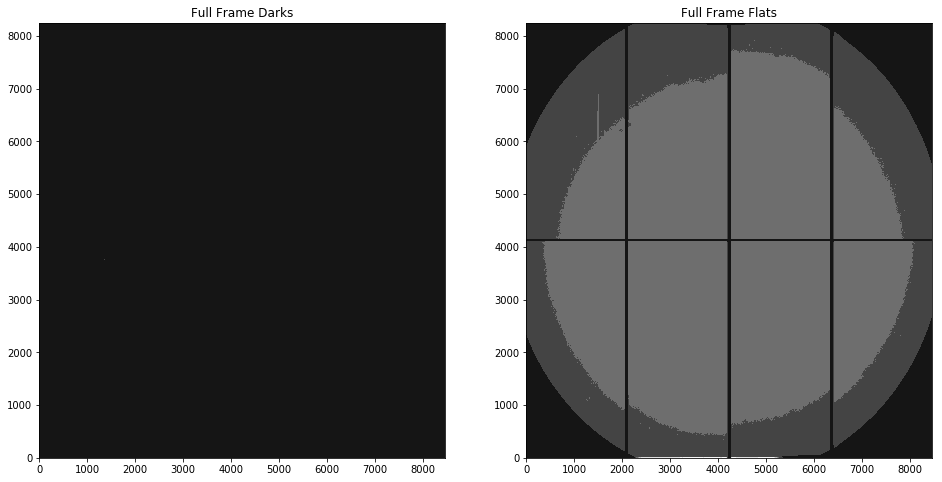

In [3]:
## ------------------------------------------------------------- ##
##     make sure your paths are updated. (first cell)            ##
## ------------------------------------------------------------- ##

print 'Location of Darks is currently set to: ', DARKS
print 'Location of Flats is currently set to: ', FLATS
print ' '

from MasterFrame import MasterFrame

dark=MasterFrame(DARKS,'Darks')                #first keyword=path, second keyword=save name
dark_full=FullFrame(1,dark)                    #number of frames, matrix of double-chip images
del dark                                       #clearing memory


flat=MasterFrame(FLATS,'Flats')
flat_full=FullFrame(1,flat)
flat_full/=np.nanmedian(flat_full)
del flat

fig,ax=plt.subplots(1,2,figsize=(16.,8.))
ax[0].contourf(dark_full[0,:,:],cmap=plt.cm.Greys_r)      #plotting to make sure combined right
ax[0].set_title('Full Frame Darks')
ax[1].contourf(flat_full[0,:,:],cmap=plt.cm.Greys_r)
ax[1].set_title('Full Frame Flats')

del dark_full
del flat_full

# --------------------------------------------------------------------------- 
# Creates Object Masks

(these are used to later only extract the parts of the data we want)

First: Objects are located using the flat_thres variable

Second: Vertical Chips are Stitched

Third: Horizontal Chips are Stitched

Fourth: Objects are Combined across Vertical Chips. 

 CHIP ALIGNMENT:
---------------------------------
|   6   |   5   |   8   |   7   |
---------------------------------
|   1   |   2   |   3   |   4   |
---------------------------------
 
------------------------------
 Working on chips 6 & 1
------------------------------
   -->>  DATA STITCHED


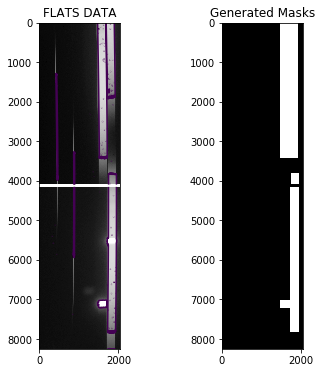

 
------------------------------
 Working on chips 5 & 2
------------------------------
   -->>  DATA STITCHED


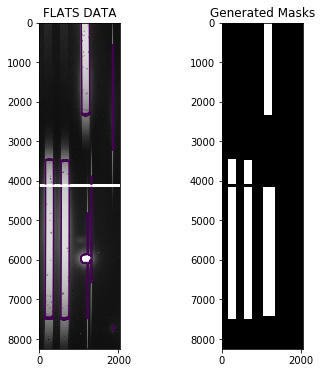

 
------------------------------
 Working on chips 8 & 3
------------------------------
   -->>  DATA STITCHED


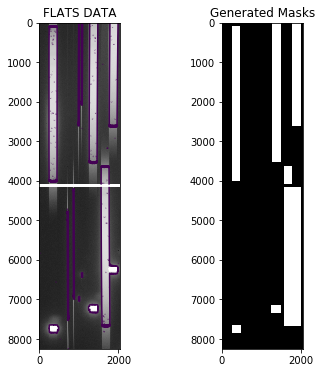

 
------------------------------
 Working on chips 7 & 4
------------------------------
   -->>  DATA STITCHED


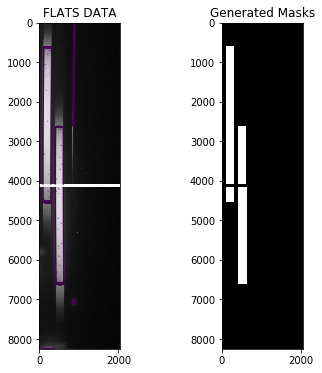

 -->> Combining Masks


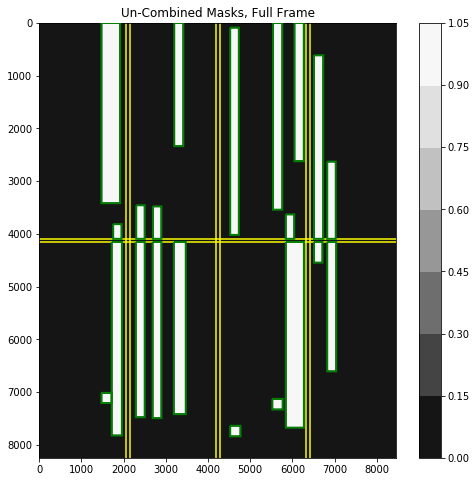

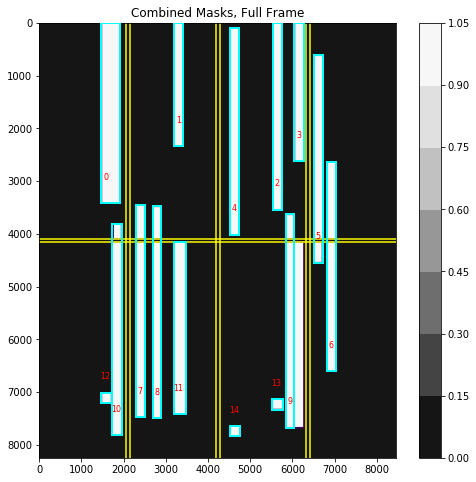

          (done)


In [2]:
## ------------------------------------------------------------- ##
## Masks are simply matrices of 1s and 0s                        ##
## ------------------------------------------------------------- ##

## user input needed:
flat_root='ift0016c'         #root name of a slit flat image
flat_thres=4000.             #flat threshold: number of counts for 'edges' of masks.

from FindMasks import FindMasks
from FindMasks import CombineMasks
#from FullFrame import FullFrame

masks=FindMasks(flat_path,flat_root,flat_thres)
mask_full=FullFrame(1,masks)
del masks

print' -->> Combining Masks'
mask_edges=CombineMasks(mask_full)
print'          (done)'

del mask_edges

# NOTES:
# Some improvements to be made, still. Works fine for now
# I need to find a way to ignore 0th order boxes. These can be trimmed later, for now
# this will be updated to be dependent on the median level of counts found

# --------------------------------------------------------------------------- 
# Define Objects: Label Target and Remove 0th-order


In [3]:
## ------------------------------------------------------------- ##
##  This rearranges masks so that the [0] element is the target  ##
##  zero-th order masks are also removed.                        ##
## ------------------------------------------------------------- ##

## using numbers output on combined mask image from cell above,define the following:
TAR=7                           #index for target
FIR=np.array([11,12,13,14])     #indices for zeroth order masks. These will be deleted


################## don't change below  ################
mask_edges=np.load('SaveData/CombinedMasks.npz')['mask_edges']
masks_fin=np.empty([mask_edges.shape[0]-len(FIR),mask_edges.shape[1]])*0.0

masks_fin[0,:]=mask_edges[TAR,:]
j=1
for i in range(0,mask_edges.shape[0]):
    if not i in FIR and i!=TAR:
        masks_fin[j,:]=mask_edges[i,:]
        j+=1
        
np.savez('SaveData/FinalMasks.npz',masks=masks_fin)
del masks_fin

# --------------------------------------------------------------------------- 
# Extract 2D Spectra for each Object #
Dark is subtracted, Flat is divided out.

In [2]:
from Extract2d import Extract2D

data=Extract2D(data_path)
del data

#output is a dictionary. Keys are formated as 'obj#', with 'obj0' being the target and 'obj1'+ being calibrators
#
#invalid value encountered in divide error - IGNORE. We are dividing full frame images which include NaNs for the gaps.

 -->> Loading Masks
          (done)
 -->> Loading Flats
              1.0
          (done)
 -->> Loading Darks


Extract2d.py:41: RuntimeWarning: invalid value encountered in divide
  dark_full=FullFrame(1,dark)/flat_full


              572.0
          (done)
 -->> Loading HeaderData
               112
          (done)


Extract2d.py:90: RuntimeWarning: invalid value encountered in divide
  image_full/=flat_full[0,:,:]


           ( EXTRACTED DATA FOR IMAGE  10 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  20 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  30 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  40 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  50 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  60 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  70 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  80 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  90 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  100 )  --    112  exposures total
           ( EXTRACTED DATA FOR IMAGE  110 )  --    112  exposures total


# --------------------------------------------------------------------------- 
# Flatten 2D Spectra #

Fits a Background function and subtracts off.

Fits a gaussian to each line of the 2D Spectra to dectect the center.

The aperture is currently done as follows: Median aperture across lambda for each frame. Varies in time. Calcualted as 3*(median(FWHM)) of the guassian fit 

In [ ]:
from FlattenSpec import FlattenSpec

flat_spec=FlattenSpec()

# --------------------------------------------------------------------------- 
# Wavelength Calibration #

Not working in notebook, will eventually update this code to run this way. 

Currently: Run via command line. I'll include instructions for this part soon.

# --------------------------------------------------------------------------- 
# Time Correltation and Apply Wavelength Calibration #
This accounts for shifts in the spectral direction by oversampling the spectra by your given factor and cross correlating in time to dectect shifts down to (1/factor) of a pixel.

After correlation, all spectra are shifted as necessary and wavelength calibration is applied.